In [1]:
def get_labels_from_filename(filename):
    parts = filename.split("-")
    if len(parts) < 7:
        return None, None
    emotion_code = parts[2]
    actor_id_str = parts[6].split(".")[0]
    
    try:
        actor_id = int(actor_id_str)
    except ValueError:
        return None, None

    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    #even → female, odd → male
    gender = "female" if actor_id % 2 == 0 else "male"
    return emotion_map.get(emotion_code, "unknown"), gender

In [3]:
import librosa
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# loading path
dataset_root = "C:/Users/Anshika/Downloads/emotion_detection/Audio"
gender_data, emotion_data = [], []

# Walk through all .wav files
for root, _, files in os.walk(dataset_root):
    for file in files:
        if file.endswith(".wav"):
            emotion, gender = get_labels_from_filename(file)
            path = os.path.join(root, file)
            if gender in ["male", "female"]:
                gender_data.append((path, gender))
            if emotion != "unknown":
                emotion_data.append((path, emotion))

# Processing Gender Data
X_gen, y_gen = [], []
for file, label in gender_data:
    try:
        X_gen.append(extract_features(file))
        y_gen.append(label)
    except: pass

le_gen = LabelEncoder()
y_gen_enc = le_gen.fit_transform(y_gen)
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_gen_enc, test_size=0.2)
clf_gen = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
joblib.dump(clf_gen, "gender_classifier.pkl")
joblib.dump(le_gen, "gender_label_encoder.pkl")

# Processing Emotion Data (only from female voices)
X_emo, y_emo = [], []
for file, label in emotion_data:
    actor_id = int(file.split("-")[6].split(".")[0])
    if actor_id >= 13:  # female only
        try:
            X_emo.append(extract_features(file))
            y_emo.append(label)
        except: pass

le_emo = LabelEncoder()
y_emo_enc = le_emo.fit_transform(y_emo)
X_train, X_test, y_train, y_test = train_test_split(X_emo, y_emo_enc, test_size=0.2)
clf_emo = RandomForestClassifier(n_estimators=150).fit(X_train, y_train)
joblib.dump(clf_emo, "emotion_classifier.pkl")
joblib.dump(le_emo, "emotion_label_encoder.pkl")

['emotion_label_encoder.pkl']

In [15]:
import tkinter as tk
from tkinter import filedialog, messagebox
import sounddevice as sd
import soundfile as sf
import librosa
import joblib
import numpy as np

# Loading models and encoders
emotion_model = joblib.load("emotion_classifier.pkl")
emotion_encoder = joblib.load("emotion_label_encoder.pkl")
gender_model = joblib.load("gender_classifier.pkl")
gender_encoder = joblib.load("gender_label_encoder.pkl")

# Feature extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)  # Trim silence
    mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# Prediction functions
def predict_gender(file_path):
    features = extract_features(file_path).reshape(1, -1)
    gender_code = gender_model.predict(features)[0]
    return gender_encoder.inverse_transform([gender_code])[0]

def predict_emotion(file_path):
    features = extract_features(file_path).reshape(1, -1)
    emotion_code = emotion_model.predict(features)[0]
    return emotion_encoder.inverse_transform([emotion_code])[0]

# File analysis 
def analyze_file(path):
    try:
        gender = predict_gender(path)
        print(f" Predicted Gender: {gender}")
        if gender.lower() != "female":
            result_label.config(text="Only female voices allowed", fg="red")
            return
        emotion = predict_emotion(path)
        result_label.config(text=f"Detected Emotion: {emotion.capitalize()}", fg="green")
    except Exception as e:
        messagebox.showerror("Error", f"Something went wrong:\n{e}")

# Uploading handler
def upload_voice():
    path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
    if path:
        analyze_file(path)

# Record handler
def record_voice():
    fs = 16000
    duration = 4  # seconds
    filename = "recorded_voice.wav"
    try:
        messagebox.showinfo("Recording", "Recording for 4 seconds...")
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
        sd.wait()
        sf.write(filename, recording, fs)
        analyze_file(filename)
    except Exception as e:
        messagebox.showerror("Recording Error", str(e))

# GUI setup
app = tk.Tk()
app.title("Emotion Detector (Female Only)")
app.geometry("400x300")
app.configure(bg="#f0f0f0")

tk.Label(app, text="Voice Emotion Detector", font=("Helvetica", 16, "bold"), bg="#f0f0f0").pack(pady=15)
tk.Button(app, text="Upload Voice Note", command=upload_voice, width=25, height=2, bg="#e0e0e0").pack(pady=10)
tk.Button(app, text="Record Voice", command=record_voice, width=25, height=2, bg="#e0e0e0").pack(pady=10)
result_label = tk.Label(app, text="Awaiting input...", font=("Helvetica", 13), fg="gray", bg="#f0f0f0")
result_label.pack(pady=20)

app.mainloop()

 Predicted Gender: female
 Predicted Gender: male


In [16]:
from sklearn.metrics import accuracy_score, classification_report
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_gen, y_gen_enc, test_size=0.2)

clf_gen = RandomForestClassifier(n_estimators=100).fit(Xg_train, yg_train)
joblib.dump(clf_gen, "gender_classifier.pkl")
joblib.dump(le_gen, "gender_label_encoder.pkl")
y_pred_gender = clf_gen.predict(Xg_test)
print(f" Gender Classifier Accuracy: {accuracy_score(yg_test, y_pred_gender) * 100:.2f}%")
print("\n Gender Classification Report:\n")
print(classification_report(yg_test, y_pred_gender, target_names=le_gen.classes_))

 Gender Classifier Accuracy: 100.00%

 Gender Classification Report:

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        97
        male       1.00      1.00      1.00       106

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203




 Emotion Classifier Accuracy: 90.72%

 Emotion Classification Report:

              precision    recall  f1-score   support

       angry       0.91      0.95      0.93        21
        calm       0.95      0.90      0.92        20
     fearful       0.89      0.80      0.84        20
       happy       0.83      0.91      0.87        11
     neutral       1.00      1.00      1.00         4
         sad       0.91      0.95      0.93        21

    accuracy                           0.91        97
   macro avg       0.91      0.92      0.92        97
weighted avg       0.91      0.91      0.91        97



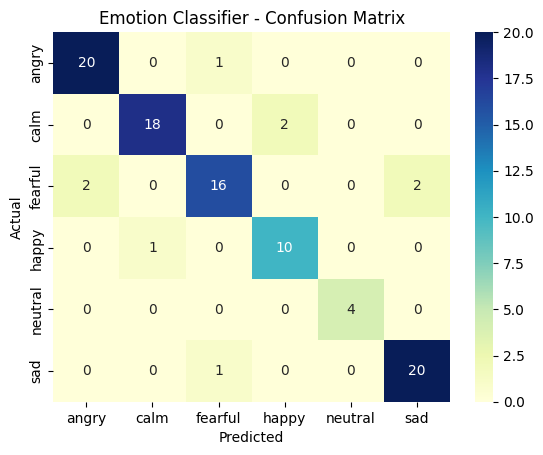

In [17]:
# Predict and evaluate emotion model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_emotion = clf_emo.predict(X_test)
accuracy_emotion = accuracy_score(y_test, y_pred_emotion)
print(f"\n Emotion Classifier Accuracy: {accuracy_emotion * 100:.2f}%")

print("\n Emotion Classification Report:\n")
print(classification_report(y_test, y_pred_emotion, target_names=le_emo.classes_))

# Visualize confusion matrix
cm_emotion = confusion_matrix(y_test, y_pred_emotion)
sns.heatmap(cm_emotion, annot=True, cmap="YlGnBu", fmt="d", 
            xticklabels=le_emo.classes_, yticklabels=le_emo.classes_)
plt.title("Emotion Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()